<p align = 'center'> <h2><b>Compreendo os Mecanismos de Processamento </br>
de Imagem no Gwyddion por Operações de Matrizes Em Python</h2></b> </p>

<h5>Desenvolvedores: José David A. Sales, Diogo P. Carvalho, Natália A. de Souza e Kayllany S. Oliveira</h5>

Inicialmente, as bibliotecas PIL, numpy e matplotlib são importadas para, respectivamente, permitir que a imagem em png seja carregada, converter a imagem para matriz e realizar operações com arrays e plotar as matrizes como imagens. 

In [235]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


A célula abaixo realiza o carregamento da imagem a ser trabalhada. Você pode adicionar nessa mesma pasta uma outra imagem de AFM ou STM, caso queira, para poder acompanhar os processos de tratamento 

In [236]:
imagem = Image.open('CD.png') #A imagem é aberta com o módulo Image importada da biblioteca PIL
imagem = imagem.convert('L')  #Converte a imagem de matriz de vetores rgb para uma escala de cinza 
imagem = np.array(imagem)    #Imagem como sendo um array numpy


Atráves da função imshow da biblioteca matplotlib é possível plotar a matriz como uma imagem. Como esta não possui vetores RGB ainda, é preciso usar o argumento cmap na função, este argumento é o mapa de cor que a imagem possuirá.

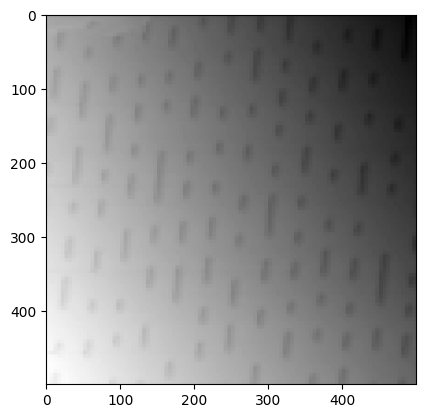

In [237]:
plt.imshow(imagem, cmap='gray')

A primeira ferramenta do <i>Gwyddion</i>  a ser explorada é o Plane Level, que permite a planagem da imagem. A função abaixa replica o funcionamento desta. O processo de planagem consiste subtrair a matriz orignal por uma matriz plano de fundo. Essa matriz plano de fundo é composto por uma função z(i,j).<br>

$$
\text{Plano de fundo} = 
\begin{bmatrix}
    z(0,0) & \cdots & z(0,x) \\
    \vdots & \ddots & \vdots \\
    z(y,0) & z(y,1) & z(y,x)
\end{bmatrix}
$$
 $$ z(i,j) = i \cdot a + j \cdot b + c $$
Os argumento i e j que a função z recebe são a coordenadas de linha e coluna da matriz. Os coeficientes a, b 
e c são encontrados atráves de uma regressão linear por meio da função las

In [238]:
def desentortar(imagem_qualquer):
    '''
    A função desentortar recebe uma matriz qualquer como argumento. A partir de uma regressão linear,
    usando o método dos mínimos quadrados, o código encontra os 
    
    '''
    
    
    x, y = np.meshgrid(np.arange(imagem_qualquer.shape[1]), np.arange(imagem_qualquer.shape[0]))
    A = np.vstack((y.ravel(),x.ravel(), np.ones(x.size))).T
    B = imagem_qualquer.ravel()
    fit = np.linalg.lstsq(A, B, rcond=None)[0]
    plano_de_fundo = fit[0] * y + fit[1] * x + fit[2]

    imagem_nivelada = imagem_qualquer - plano_de_fundo
    
    return imagem_nivelada, plano_de_fundo

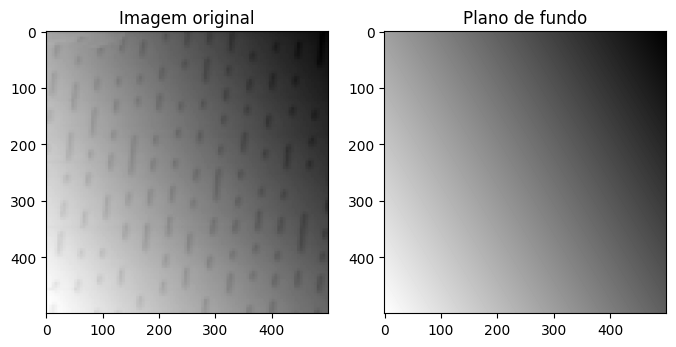

In [239]:
fundo = desentortar(imagem)[1]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(imagem, cmap= 'gray')
axs[0].set_title('Imagem original')

axs[1].imshow(fundo, cmap= 'gray')
axs[1].set_title('Plano de fundo')

plt.show()

Text(0.5, 1.0, 'Imagem retificada')

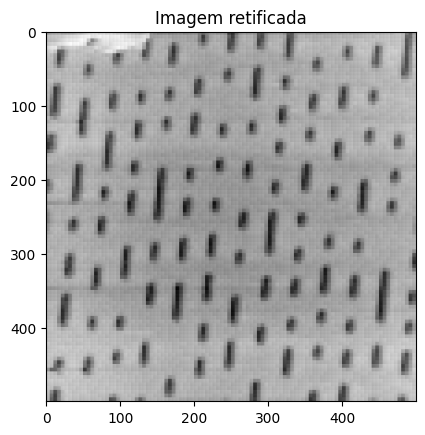

In [247]:
desentortada = desentortar(imagem)[0]

plt.imshow(desentortada,cmap='gray')
plt.title('Imagem retificada')

In [241]:
def normalizar(matriz_qualquer):
    max_antigo = matriz_qualquer.max()
    min_antigo = matriz_qualquer.min()
    max_novo = 255
    min_novo = 0
    
    matriz_normalizada = (matriz_qualquer - min_antigo) * (max_novo - min_novo) / (max_antigo - min_antigo) + min_novo
    return matriz_normalizada

In [242]:
plano_normal = normalizar(desentortada)

In [243]:
def filtro_mediana(imagem_qualquer):
    
    plano_de_medianas = np.zeros((imagem_qualquer.shape[0], imagem_qualquer.shape[1]))
    for i in range(imagem_qualquer.shape[0]):
        mediana = np.median(imagem_qualquer[i])
        for j in range(imagem_qualquer.shape[1]):
            plano_de_medianas[i][j] = mediana 

    imagem_filtrada = imagem_qualquer - plano_de_medianas
    
    return imagem_filtrada,plano_de_medianas

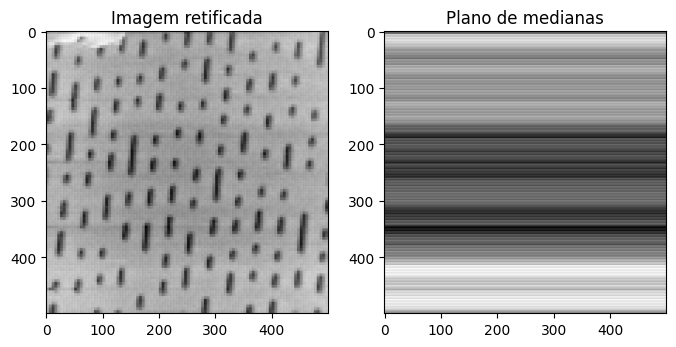

In [244]:

fundomediana = filtro_mediana(plano_normal)[1]
final = normalizar(filtro_mediana(plano_normal)[0])
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Exibe a primeira imagem na primeira subtrama.
axs[0].imshow(plano_normal, cmap= 'gray')
axs[0].set_title('Imagem retificada')

# Exibe a segunda imagem na segunda subtrama.
axs[1].imshow(fundomediana, cmap= 'gray')
axs[1].set_title('Plano de medianas')

plt.show()


In [245]:
def colorindo(imagem_cinza, matriz_cor):
    
    if matriz_cor.shape[0] != 3:
        return('Falha')
    
    cor_normalizada = matriz_cor/matriz_cor.max()
    
    
    linhas, colunas = imagem_cinza.shape
    matriz_colorida = np.empty((linhas, colunas, 3), dtype=int) 

    for i in range(linhas):
        for j in range(colunas):
            matriz_colorida[i, j] = imagem_cinza[i, j] * cor_normalizada
            
    
    
    return matriz_colorida



Text(0.5, 1.0, 'Imagem colorida')

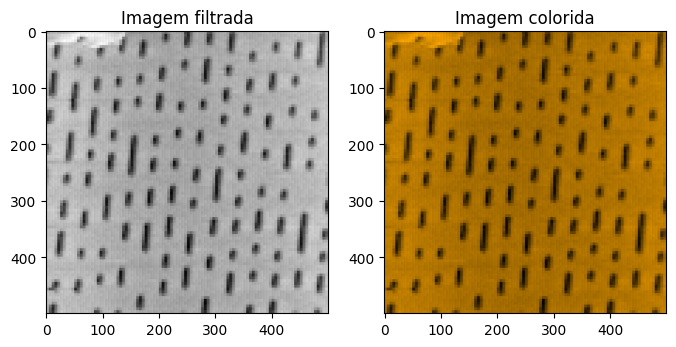

In [246]:
cor = np.array([230,152,0])

colorida = colorindo(final, cor)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Exibe a primeira imagem na primeira subtrama.
axs[0].imshow(final, cmap= 'gray')
axs[0].set_title('Imagem filtrada')

# Exibe a segunda imagem na segunda subtrama.
axs[1].imshow(colorida, cmap= 'gray')
axs[1].set_title('Imagem colorida')

[1] Como converter imagens em array NumPy? – Acervo Lima. Disponível em: <https://acervolima.com/como-converter-imagens-em-array-numpy/>. Acesso em: 23 set. 2023.

[2‌] Como remover elementos específicos de uma array NumPy? – Acervo Lima. Disponível em: <https://acervolima.com/como-remover-elementos-especificos-de-uma-array-numpy/>. Acesso em: 23 set. 2023.

‌